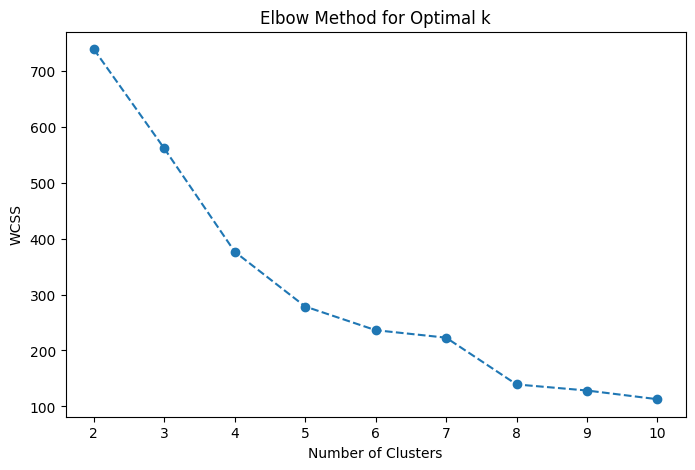

Davies-Bouldin Index: 0.98
Silhouette Score: 0.43


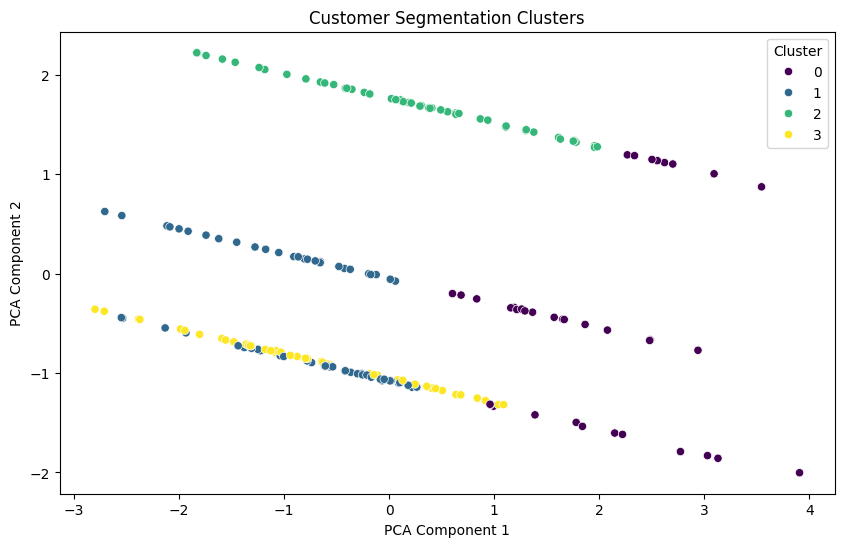

Clustering results saved to Customer_Clusters.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

# Load Data
customers = pd.read_csv("/Intern Project/Customers.csv")
transactions = pd.read_csv("/Intern Project/Transactions.csv")

# Aggregate Transaction Data
customer_spending = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum"
}).reset_index()

# Merge with Customer Data
customer_profile = customers.merge(customer_spending, on="CustomerID", how="left").fillna(0)

# Encode Categorical Data
customer_profile = pd.get_dummies(customer_profile, columns=["Region"], drop_first=True)

# Feature Scaling
scaler = StandardScaler()
features = ["TotalValue", "Quantity"] + [col for col in customer_profile.columns if "Region_" in col]
scaled_features = scaler.fit_transform(customer_profile[features])

# Find Optimal Clusters using Elbow Method
wcss = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='dashed')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

# Applying KMeans with chosen k
optimal_k = 4  # Change based on Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)
customer_profile["Cluster"] = kmeans.labels_

# Compute DB Index & Silhouette Score
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Visualizing Clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)
plt.figure(figsize=(10,6))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=customer_profile["Cluster"], palette="viridis")
plt.title("Customer Segmentation Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Save Clustering Results
customer_profile.to_csv("/Intern Project/Customer_Clusters.csv", index=False)
print("Clustering results saved to Customer_Clusters.csv")
